In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the FedELIM algorithm
def fedelim(K, M, means, delta, C, communicate_every_round=False):
    n = 0  # iteration counter
    total_pulls = 0
    comm_cost = 0
    mu_hat = np.zeros((K, M))
    mu_hat_g = np.zeros(K)  # empirical means
    S_m = [list(range(K)) for _ in range(M)]  # active arms for each client
    S_g = list(range(K))  # global active arms
    run = True

    alpha_l = lambda n: np.sqrt(2 * np.log(8 * K * M * n**2 / delta) / n)
    alpha_g = lambda n: np.sqrt(2 * np.log(8 * K * n**2 / delta) / (M * n))

    while run:
        n += 1  # increment round number
        for m in range(M):
            if len(np.union1d(S_m[m],S_g)) > 1:
                for k in np.union1d(S_m[m],S_g):
                    arm_reward = np.random.normal(means[k, m], 1)  # simulate pulling the arm
                    total_pulls += 1
                    mu_hat[k, m] = (mu_hat[k, m] * (n - 1) + arm_reward) / n  # update empirical mean

                max_mu_m = max(mu_hat[k, m] for k in S_m[m])
                S_m[m] = [k for k in S_m[m] if max_mu_m - mu_hat[k, m] < 2 * alpha_l(n)]

        if len(S_g) > 1 and (communicate_every_round or (n in [2 ** t for t in range(int(np.log2(n)) + 1)])):
            comm_cost = comm_cost + (C * M * len(S_g))
            for k in S_g:
                mu_k = np.mean([mu_hat[k, m] for m in range(M)])  # average empirical mean across clients
                mu_hat_g[k] = mu_k

            max_mu_g = max(mu_hat_g[k] for k in S_g)
            S_g = [k for k in S_g if max_mu_g - mu_hat_g[k] < 2 * alpha_g(n)]

        # if len(S_g) == 1:
            #print(f"Globally declared arm {S_g[0]} as the best arm.")

        if all(len(S_m[m]) == 1 for m in range(M)) and len(S_g) == 1:
            run = False

    total_cost = comm_cost + total_pulls
    return total_pulls, comm_cost, total_cost

In [31]:
# Running the experiment
def run_experiments(K, M, means, deltas, C_values, runs=100):
    results = {} #Arm pulls
    costs = {} #Total cost
    comm = {} #Commuication cost
    for delta in deltas:

        #Add FedELIM0 separately for C=0

        total_pulls_list = []
        comm_cost_list = []
        total_cost_list = []
        np.random.seed(10)
        for _ in range(runs):
            # FedELIM0 (communicate every round)
            total_pulls, comm_cost, total_cost = fedelim(K, M, means, delta, 0, communicate_every_round=True)
            total_pulls_list.append(total_pulls)
            comm_cost_list.append(comm_cost)
            total_cost_list.append(total_cost)

        mean_pulls = np.mean(total_pulls_list)
        mean_comm_cost = np.mean(comm_cost_list)
        mean_total_cost = np.mean(total_cost_list)
        std_pulls = np.std(total_pulls_list)
        std_comm_cost = np.std(comm_cost_list)
        std_total_cost = np.std(total_cost_list)

        results[(delta, 0, 'FedELIM0')] = (mean_pulls, std_pulls)
        costs[(delta, 0, 'FedELIM0')] = (mean_total_cost, std_total_cost)
        comm[(delta, 0, 'FedELIM0')] = (mean_comm_cost, std_comm_cost)

        for C in C_values:
        #Add FedELIM0 separately for C=0

            total_pulls_list = []
            comm_cost_list = []
            total_cost_list = []
            np.random.seed(10)
            for _ in range(runs):
                # FedELIM0 (communicate every round)
                total_pulls, comm_cost, total_cost = fedelim(K, M, means, delta, C , communicate_every_round=False)
                total_pulls_list.append(total_pulls)
                comm_cost_list.append(comm_cost)
                total_cost_list.append(total_cost)


            mean_pulls = np.mean(total_pulls_list)
            mean_comm_cost = np.mean(comm_cost_list)
            mean_total_cost = np.mean(total_cost_list)
            std_pulls = np.std(total_pulls_list, ddof=1)
            std_comm_cost = np.std(comm_cost_list, ddof=1)
            std_total_cost = np.std(total_cost_list, ddof=1)

            results[(delta, C, 'FedELIM')] = (mean_pulls, std_pulls)
            costs[(delta, C, 'FedELIM')] = (mean_total_cost, std_total_cost)
            comm[(delta, C, 'FedELIM')] = (mean_comm_cost, std_comm_cost)

    return results, costs, comm

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Updated plotting function
def plot_results(results, costs, deltas, C_values):
    colors = ['orange', 'blue', 'green', 'red']  # Colors for the 4 cases: FedELIM0 C=0, FedELIM C=0, C=10, C=100
    labels = ["FedELIM0 C = 0", "FedELIM C = 0", "FedELIM C = 10", "FedELIM C = 100"]

    x_pos = np.arange(len(deltas))
    width = 0.2  # Bar width

    fig, ax = plt.subplots()

    # First bar is for FedELIM0 with C=0
    fedelim0_means = [results[(delta, 0, 'FedELIM0')][0] for delta in deltas]
    fedelim0_stds = [results[(delta, 0, 'FedELIM0')][1] for delta in deltas]
    ax.bar(x_pos, fedelim0_means, width, yerr=fedelim0_stds, label="FedELIM0 C = 0", color=colors[0])

    # Following bars for FedELIM with C=0, C=10, and C=100
    for i, C in enumerate([0, 10, 100]):
        means = [costs[(delta, C, 'FedELIM')][0] for delta in deltas]
        stds = [costs[(delta, C, 'FedELIM')][1] for delta in deltas]
        ax.bar(x_pos + (i + 1)*width, means, width, yerr=stds, label=labels[i + 1], color=colors[i + 1])

    # Set x-axis labels to ln(1/delta)
    ln_deltas = [np.log(1/delta) for delta in deltas]
    ax.set_xticks(x_pos + 1.5*width)
    ax.set_xticklabels([f'{np.log(1/delta)}' for delta in deltas])

    ax.set_xlabel('ln(1/delta)')
    ax.set_ylabel('Total Cost')
    ax.set_title('Total Cost vs ln(1/delta) for Different Communication Costs')
    ax.legend()

    plt.show()

In [29]:
# Main execution
means = np.array([[0.9, 0.1, 0.1],
                  [0.1, 0.9, 0.1],
                  [0.1, 0.1, 0.9],
                  [0.5, 0.5, 0.5]])

K, M = means.shape
deltas = [np.exp(-1), np.exp(-3), np.exp(-5)]  # Different delta values
C_values = [0, 10, 100]  # Different communication costs

# Run experiments and plot results
results, costs, comm = run_experiments(K, M, means, deltas, C_values, 10)
# plot_results(results, deltas, C_values)

In [ ]:
results

{(0.3678794411714424, 0, 'FedELIM0'): (70940.5, 141678.97222047456),
 (0.3678794411714424, 0, 'FedELIM'): (32995.4, 14989.802542617654),
 (0.3678794411714424, 10, 'FedELIM'): (32995.4, 14989.802542617654),
 (0.3678794411714424, 100, 'FedELIM'): (32995.4, 14989.802542617654),
 (0.04978706836786394, 0, 'FedELIM0'): (24197.0, 10367.158231646703),
 (0.04978706836786394, 0, 'FedELIM'): (25864.8, 11622.97936369539),
 (0.04978706836786394, 10, 'FedELIM'): (25864.8, 11622.97936369539),
 (0.04978706836786394, 100, 'FedELIM'): (25864.8, 11622.97936369539),
 (0.006737946999085467, 0, 'FedELIM0'): (24320.7, 7361.105895855595),
 (0.006737946999085467, 0, 'FedELIM'): (25872.1, 5904.174633257387),
 (0.006737946999085467, 10, 'FedELIM'): (25872.1, 5904.174633257387),
 (0.006737946999085467, 100, 'FedELIM'): (25872.1, 5904.174633257387)}

In [ ]:
costs

{(0.3678794411714424, 0, 'FedELIM0'): (70940.5, 141678.97222047456),
 (0.3678794411714424, 0, 'FedELIM'): (32995.4, 14989.802542617654),
 (0.3678794411714424, 10, 'FedELIM'): (34606.4, 15067.66001297702),
 (0.3678794411714424, 100, 'FedELIM'): (49105.4, 15778.499937150762),
 (0.04978706836786394, 0, 'FedELIM0'): (24197.0, 10367.158231646703),
 (0.04978706836786394, 0, 'FedELIM'): (25864.8, 11622.97936369539),
 (0.04978706836786394, 10, 'FedELIM'): (27451.8, 11688.170285473352),
 (0.04978706836786394, 100, 'FedELIM'): (41734.8, 12276.502051570806),
 (0.006737946999085467, 0, 'FedELIM0'): (24320.7, 7361.105895855595),
 (0.006737946999085467, 0, 'FedELIM'): (25872.1, 5904.174633257387),
 (0.006737946999085467, 10, 'FedELIM'): (27468.1, 5947.7197395304365),
 (0.006737946999085467, 100, 'FedELIM'): (41832.1, 6348.590245085911)}

In [ ]:
comm

{(0.3678794411714424, 0, 'FedELIM0'): (0.0, 0.0),
 (0.3678794411714424, 0, 'FedELIM'): (0.0, 0.0),
 (0.3678794411714424, 10, 'FedELIM'): (1623.0, 127.63228431709588),
 (0.3678794411714424, 100, 'FedELIM'): (16230.0, 1276.3228431709588),
 (0.04978706836786394, 0, 'FedELIM0'): (0.0, 0.0),
 (0.04978706836786394, 0, 'FedELIM'): (0.0, 0.0),
 (0.04978706836786394, 10, 'FedELIM'): (1641.0, 86.08135686662938),
 (0.04978706836786394, 100, 'FedELIM'): (16410.0, 860.8135686662937),
 (0.006737946999085467, 0, 'FedELIM0'): (0.0, 0.0),
 (0.006737946999085467, 0, 'FedELIM'): (0.0, 0.0),
 (0.006737946999085467, 10, 'FedELIM'): (1587.0, 38.600518131237564),
 (0.006737946999085467, 100, 'FedELIM'): (15870.0, 386.00518131237567)}

In [ ]:
import numpy as np

def compute_suboptimality_gaps(K, M, means):
    """
    Computes the suboptimality gaps Delta_k,m and Delta_k.

    Parameters:
    - K: Number of arms
    - M: Number of clients
    - means: K x M matrix of means where means[k, m] is the mean of arm k for client m

    Returns:
    - Delta_km: Matrix of Delta_k,m values
    - Delta_k: Array of Delta_k values
    """
    # Initialize the Delta matrices
    Delta_km = np.zeros((K, M))
    Delta_k = np.zeros(K)

    for m in range(M):
        # Find the best local arm for client m (maximum mean)
        k_m_star = np.argmax(means[:, m])
        for k in range(K):
            # Compute Delta_k,m as the difference between the best arm's mean and the current arm's mean
            Delta_km[k, m] = means[k_m_star, m] - means[k, m]

    # Find the global best arm across all clients
    global_means = np.mean(means, axis=1)  # Average across clients
    k_star = np.argmax(global_means)

    for k in range(K):
        # Compute Delta_k as the difference between the best global arm's mean and the current arm's mean
        Delta_k[k] = global_means[k_star] - global_means[k]

    return Delta_km, Delta_k

def compute_T_km(K, M, Delta_km, Delta_k, delta):
    """
    Computes the value of T_k,m and T_k based on the given formulas.

    Parameters:
    - K: Number of arms
    - M: Number of clients
    - Delta_km: Matrix of Delta_k,m values
    - Delta_k: Array of Delta_k values
    - delta: Global delta value

    Returns:
    - T_km: Matrix of T_k,m values
    - T_k: Array of T_k values
    """
    T_km = np.zeros((K, M))
    T_k = np.zeros(K)

    for k in range(K):
        for m in range(M):
            if Delta_km[k, m] != 0:  # Avoid division by zero
                # Compute T_k,m
                T_km[k, m] = 102 * (np.log(64 * np.sqrt(8 * K * M / delta) / (Delta_km[k, m] ** 2)) / (Delta_km[k, m] ** 2)) + 1
            else:
                T_km[k, m] = 0  # If no gap, set T_km to 0

        if Delta_k[k] != 0:  # Avoid division by zero
            # Compute T_k (global)
            T_k[k] = 102 * (np.log(64 * np.sqrt(8 * K / (M * delta)) / (M * Delta_k[k] ** 2)) / (M * Delta_k[k] ** 2)) + 1
        else:
            T_k[k] = 0  # If no gap, set T_k to 0

    return T_km, T_k

means = np.array([[0.9, 0.1, 0.1],
                  [0.1, 0.9, 0.1],
                  [0.1, 0.1, 0.9],
                  [0.5, 0.5, 0.5]])

K, M = means.shape
deltas = [np.exp(-1), np.exp(-3), np.exp(-5)]

Delta_km, Delta_k = compute_suboptimality_gaps(K, M, means)

for delta in deltas:
    print(f"Delta = {delta}")
# Compute the suboptimality gaps


    # Compute T_km and T_k
    T_km, T_k = compute_T_km(K, M, Delta_km, Delta_k, delta)

    print("Delta_km values (suboptimality gaps for each arm and client):")
    print(Delta_km)
    print("\nDelta_k values (global suboptimality gaps for each arm):")
    print(Delta_k)
    print("\nT_km values (per arm and client):")
    print(T_km)
    print("\nT_k values (global):")
    print(T_k)

Delta = 0.3678794411714424
Delta_km values (suboptimality gaps for each arm and client):
[[0.  0.8 0.8]
 [0.8 0.  0.8]
 [0.8 0.8 0. ]
 [0.4 0.4 0.4]]

Delta_k values (global suboptimality gaps for each arm):
[0.13333333 0.13333333 0.13333333 0.        ]

T_km values (per arm and client):
[[   0.         1178.3579949  1178.3579949 ]
 [1178.3579949     0.         1178.3579949 ]
 [1178.3579949  1178.3579949     0.        ]
 [5594.19463481 5594.19463481 5594.19463481]]

T_k values (global):
[16780.58390444 16780.58390444 16780.58390444     0.        ]
Delta = 0.04978706836786394
Delta_km values (suboptimality gaps for each arm and client):
[[0.  0.8 0.8]
 [0.8 0.  0.8]
 [0.8 0.8 0. ]
 [0.4 0.4 0.4]]

Delta_k values (global suboptimality gaps for each arm):
[0.13333333 0.13333333 0.13333333 0.        ]

T_km values (per arm and client):
[[   0.         1337.7329949  1337.7329949 ]
 [1337.7329949     0.         1337.7329949 ]
 [1337.7329949  1337.7329949     0.        ]
 [6231.69463481 6231.

In [ ]:
import numpy as np

def compute_suboptimality_gaps(K, M, means):
    """
    Computes the suboptimality gaps Delta_k,m and Delta_k.

    Parameters:
    - K: Number of arms
    - M: Number of clients
    - means: K x M matrix of means where means[k, m] is the mean of arm k for client m

    Returns:
    - Delta_km: Matrix of Delta_k,m values
    - Delta_k: Array of Delta_k values
    """
    # Initialize the Delta matrices
    Delta_km = np.zeros((K, M))
    Delta_k = np.zeros(K)

    for m in range(M):
        # Find the best local arm for client m (maximum mean)
        k_m_star = np.argmax(means[:, m])
        for k in range(K):
            # Compute Delta_k,m as the difference between the best arm's mean and the current arm's mean
            Delta_km[k, m] = means[k_m_star, m] - means[k, m]

    # Find the global best arm across all clients
    global_means = np.mean(means, axis=1)  # Average across clients
    k_star = np.argmax(global_means)

    for k in range(K):
        # Compute Delta_k as the difference between the best global arm's mean and the current arm's mean
        Delta_k[k] = global_means[k_star] - global_means[k]

    return Delta_km, Delta_k

def compute_T_km(K, M, Delta_km, Delta_k, delta):
    """
    Computes the value of T_k,m and T_k based on the given formulas.

    Parameters:
    - K: Number of arms
    - M: Number of clients
    - Delta_km: Matrix of Delta_k,m values
    - Delta_k: Array of Delta_k values
    - delta: Global delta value

    Returns:
    - T_km: Matrix of T_k,m values
    - T_k: Array of T_k values
    """
    T_km = np.zeros((K, M))
    T_k = np.zeros(K)

    for k in range(K):
        for m in range(M):
            if Delta_km[k, m] != 0:  # Avoid division by zero
                # Compute T_k,m
                T_km[k, m] = 102 * (np.log(64 * np.sqrt(8 * K * M / delta) / (Delta_km[k, m] ** 2)) / (Delta_km[k, m] ** 2)) + 1
            else:
                T_km[k, m] = 0  # If no gap, set T_km to 0

        if Delta_k[k] != 0:  # Avoid division by zero
            # Compute T_k (global)
            T_k[k] = 102 * (np.log(64 * np.sqrt(8 * K / (M * delta)) / (M * Delta_k[k] ** 2)) / (M * Delta_k[k] ** 2)) + 1
        else:
            T_k[k] = 0  # If no gap, set T_k to 0

    return T_km, T_k

def compute_total_T(K, M, T_km, T_k):
    """
    Computes the total value of T, which is the summation of max(T_km, T_k) for each k and m.

    Parameters:
    - K: Number of arms
    - M: Number of clients
    - T_km: Matrix of T_k,m values
    - T_k: Array of T_k values

    Returns:
    - total_T: The total value of T
    """
    total_T = 0

    for k in range(K):
        for m in range(M):
            # Summing the maximum of T_k,m and T_k for each arm k and client m
            total_T += max(T_km[k, m], T_k[k])

    return total_T

In [ ]:
Delta_km, Delta_k = compute_suboptimality_gaps(K, M, means)

for delta in deltas:
    print(f"Delta = {delta}")
    T_km, T_k = compute_T_km(K, M, Delta_km, Delta_k, delta)

# Compute the total value of T
    total_T = compute_total_T(K, M, T_km, T_k)
    print(total_T)

Delta = 0.3678794411714424
167807.83904435142
Delta = 0.04978706836786394
186932.83904435142
Delta = 0.006737946999085467
206057.83904435142


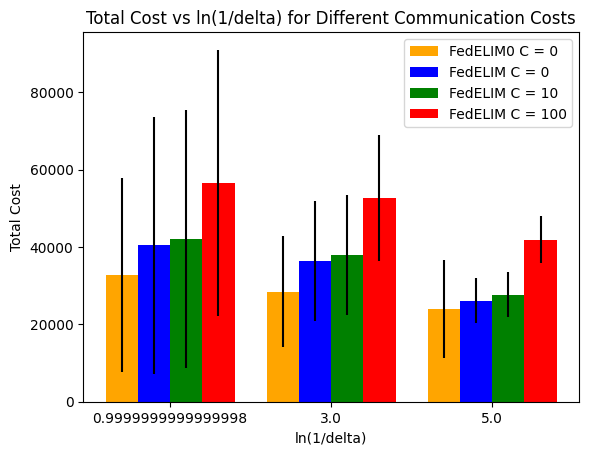

In [ ]:
plot_results(results, costs, deltas, C_values)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define the FedELIM algorithm
def fedelim2(K, M, means, delta, C, H, communicate_every_round=False):
    n = 0  # iteration counter
    total_pulls = 0
    comm_cost = 0
    mu_hat = np.zeros((K, M))
    mu_hat_g = np.zeros(K)   # empirical means
    S_m = [list(range(K)) for _ in range(M)]  # active arms for each client
    S_g = list(range(K))  # global active arms
    run = True
    alpha_l = lambda n: np.sqrt(2 * np.log(8 * K * M * n**2 / delta) / n)
    alpha_g = lambda n: np.sqrt(2 * np.log(8 * K * n**2 / delta) / (M * n))
    
    while run:
        n += 1  # increment round number

        for m in range(M):
            if len(S_m[m]) > 1:
                for k in np.union1d(S_m[m], S_g):
                    arm_reward = np.random.normal(means[k, m], 1)  # simulate pulling the arm
                    total_pulls += 1
                    mu_hat[k, m] = (mu_hat[k, m] * (n - 1) + arm_reward) / n  # update empirical mean

                max_mu_m = max(mu_hat[k, m] for k in S_m[m])
                S_m[m] = [k for k in S_m[m] if max_mu_m - mu_hat[k, m] < 2 * alpha_l(n)]

        # Communication step: communicate every H rounds or if communicate_every_round is True
        if len(S_g) > 1 and (communicate_every_round or n % H == 0):
            comm_cost += (C * M * len(S_g))
            for k in S_g:
                mu_k = np.mean([mu_hat[k, m] for m in range(M)])  # average empirical mean across clients
                mu_hat_g[k] = mu_k

            max_mu_g = max(mu_hat_g[k] for k in S_g)
            S_g = [k for k in S_g if max_mu_g - mu_hat_g[k] < 2 * alpha_g(n)]

        # Check termination conditions
        if all(len(S_m[m]) == 1 for m in range(M)) and len(S_g) == 1:
            run = False

    total_cost = comm_cost + total_pulls
    return total_pulls, comm_cost, total_cost

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define the FedELIM algorithm with flexible communication strategy
def fedelim(K, M, means, delta, C, H=1, communicate_periodic=True):
    n = 0  # iteration counter
    total_pulls = 0
    comm_cost = 0
    mu_hat = np.zeros((K, M))
    mu_hat_g = np.zeros(K)  # empirical means
    S_m = [list(range(K)) for _ in range(M)]  # active arms for each client
    S_g = list(range(K))  # global active arms
    run = True

    alpha_l = lambda n: np.sqrt(2 * np.log(8 * K * M * n**2 / delta) / n)
    alpha_g = lambda n: np.sqrt(2 * np.log(8 * K * n**2 / delta) / (M * n))

    while run:
        n += 1  # increment round number
        for m in range(M):
            if len(np.union1d(S_m[m], S_g)) > 1:
                for k in np.union1d(S_m[m], S_g):
                    arm_reward = np.random.normal(means[k, m], 1)  # simulate pulling the arm
                    total_pulls += 1
                    mu_hat[k, m] = (mu_hat[k, m] * (n - 1) + arm_reward) / n  # update empirical mean

                max_mu_m = max(mu_hat[k, m] for k in S_m[m])
                S_m[m] = [k for k in S_m[m] if max_mu_m - mu_hat[k, m] < 2 * alpha_l(n)]

        # Determine communication strategy
        if len(S_g) > 1:
            if communicate_periodic:
                should_communicate = (n % H == 0)  # Periodic communication
            else:
                should_communicate = (n & (n - 1) == 0)  # Exponential communication, check if n is a power of 2

            if should_communicate:
                comm_cost += (C * M * len(S_g))
                for k in S_g:
                    mu_k = np.mean([mu_hat[k, m] for m in range(M)])  # average empirical mean across clients
                    mu_hat_g[k] = mu_k

                max_mu_g = max(mu_hat_g[k] for k in S_g)
                S_g = [k for k in S_g if max_mu_g - mu_hat_g[k] < 2 * alpha_g(n)]

        # Stopping condition
        if all(len(S_m[m]) == 1 for m in range(M)) and len(S_g) == 1:
            run = False

    total_cost = comm_cost + total_pulls
    return total_pulls, comm_cost, total_cost

In [48]:
# Running the experiment
def run_experiments2(K, M, means, deltas, C, H_values, runs=100):
    results = {} #Arm pulls
    costs = {} #Total cost
    comm = {} #Commuication cost
    for delta in deltas:

        #Add FedELIM0 separately for C=0

        total_pulls_list = []
        comm_cost_list = []
        total_cost_list = []
        for _ in range(runs):
            # FedELIM0 (communicate every round)
            total_pulls, comm_cost, total_cost = fedelim(K, M, means, delta, C, 1, communicate_periodic=False)
            total_pulls_list.append(total_pulls)
            comm_cost_list.append(comm_cost)
            total_cost_list.append(total_cost)

        mean_pulls = np.mean(total_pulls_list)
        mean_comm_cost = np.mean(comm_cost_list)
        mean_total_cost = np.mean(total_cost_list)
        std_pulls = np.std(total_pulls_list)
        std_comm_cost = np.std(comm_cost_list)
        std_total_cost = np.std(total_cost_list)

        results[(delta, 10, 'FedELIM')] = (mean_pulls, std_pulls)
        costs[(delta, 10, 'FedELIM')] = (mean_total_cost, std_total_cost)
        comm[(delta, 10, 'FedELIM')] = (mean_comm_cost, std_comm_cost)

        for H in H_values:
        #Add FedELIM0 sepa
        # rately for C=0

            total_pulls_list = []
            comm_cost_list = []
            total_cost_list = []
            for _ in range(runs):
                # FedELIM0 (communicate every round)   
                total_pulls, comm_cost, total_cost = fedelim(K, M, means, delta, C , H, communicate_periodic=True)
                total_pulls_list.append(total_pulls)
                comm_cost_list.append(comm_cost)
                total_cost_list.append(total_cost)


            mean_pulls = np.mean(total_pulls_list)
            mean_comm_cost = np.mean(comm_cost_list)
            mean_total_cost = np.mean(total_cost_list)
            std_pulls = np.std(total_pulls_list)
            std_comm_cost = np.std(comm_cost_list)
            std_total_cost = np.std(total_cost_list)

            results[(delta, C, f'Periodic_{H}')] = (mean_pulls, std_pulls)
            costs[(delta,C , f'Periodic_{H}')] = (mean_total_cost, std_total_cost)
            comm[(delta, C, f'Periodic_{H}')] = (mean_comm_cost, std_comm_cost)

    return results, costs, comm

In [57]:
# Main execution
means = np.array([[0.9, 0.1, 0.1],
                  [0.1, 0.9, 0.1],
                  [0.1, 0.1, 0.9],
                  [0.5, 0.5, 0.5]])

K, M = means.shape
deltas = [np.exp(-1), np.exp(-3), np.exp(-5)]  # Different delta values
C_values = [0, 10, 100]  # Different communication costs

# Run experiments and plot results
results2, costs2, comm2 = run_experiments2(K, M, means, deltas, 10, [1,5,10], runs=100)

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Updated plotting function
def plot_results2(comm, deltas):
    colors = ['orange', 'blue', 'green', 'red']  # Colors for the 4 cases: FedELIM, Periodic H=1, H=5, H=10
    labels = ["FedELIM", "Periodic H=1", "Periodic H=5", "Periodic H=10"]

    x_pos = np.arange(len(deltas))
    width = 0.2  # Bar width

    fig, ax = plt.subplots()

    # First bar is for FedELIM with C=10, applying ln transformation to means
    fedelim_means = [np.log(comm[(delta, 10, 'FedELIM')][0]) for delta in deltas]
    fedelim_stds = [comm[(delta, 10, 'FedELIM')][1] / comm[(delta, 10, 'FedELIM')][0] for delta in deltas]  # Relative error after log
    ax.bar(x_pos, fedelim_means, width, yerr=fedelim_stds, label="FedELIM C = 10", color=colors[0])

    # Following bars for Periodic with H=1, H=5, and H=10, applying ln transformation
    for i, H in enumerate([1, 5, 10]):
        means = [np.log(comm[(delta, 10, f'Periodic_{H}')][0]) for delta in deltas]
        stds = [comm[(delta, 10, f'Periodic_{H}')][1] / comm[(delta, 10, f'Periodic_{H}')][0] for delta in deltas]  # Relative error
        ax.bar(x_pos + (i + 1)*width, means, width, yerr=stds, label=labels[i + 1], color=colors[i + 1])

    # Set x-axis labels to ln(1/delta)
    ln_deltas = [np.log(1/delta) for delta in deltas]
    ax.set_xticks(x_pos + 1.5*width)
    ax.set_xticklabels([f'{np.ceil(np.log(1/delta))}' for delta in deltas])

    # Labels and title
    ax.set_xlabel('ln(1/delta)')
    ax.set_ylabel('ln(Communication Cost)')
    ax.set_title('ln(Communication Cost) vs ln(1/delta) for Different Algorithms')
    ax.legend()

    # Show plot
    plt.show()


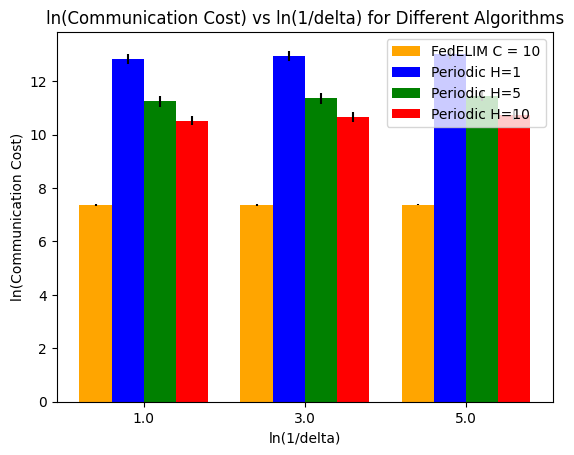

In [64]:
plot_results2(comm2, deltas)

In [65]:
print(comm2)

{(0.3678794411714424, 10, 'FedELIM'): (1574.4, 38.29673615335908), (0.3678794411714424, 10, 'Periodic_1'): (380250.6, 71075.30748185336), (0.3678794411714424, 10, 'Periodic_5'): (76242.6, 15765.445672102009), (0.3678794411714424, 10, 'Periodic_10'): (37099.2, 6395.869867344081), (0.04978706836786394, 10, 'FedELIM'): (1590.6, 44.086732698171225), (0.04978706836786394, 10, 'Periodic_1'): (415948.5, 80452.37115679064), (0.04978706836786394, 10, 'Periodic_5'): (85850.7, 16916.590983705908), (0.04978706836786394, 10, 'Periodic_10'): (41987.1, 7789.474731328165), (0.006737946999085467, 10, 'FedELIM'): (1605.0, 46.184412955021955), (0.006737946999085467, 10, 'Periodic_1'): (449111.4, 73896.5521796518), (0.006737946999085467, 10, 'Periodic_5'): (92286.6, 17107.03149117345), (0.006737946999085467, 10, 'Periodic_10'): (45390.3, 7920.008517040876)}


In [66]:
# Main execution
means = np.array([[0.9, 0.1, 0.1],
                  [0.1, 0.9, 0.1],
                  [0.1, 0.1, 0.9],
                  [0.5, 0.5, 0.5]])

K, M = means.shape
deltas = [np.exp(-1), np.exp(-3), np.exp(-5)]  # Different delta values
C_values = [0, 10, 100]  # Different communication costs

# Run experiments and plot results
results2, costs2, comm2 = run_experiments2(K, M, means, deltas, 10, [1,10, 100, 1000, 10^4, 10^5], runs=100)

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Updated plotting function
def plot_results3(comm, deltas):
    colors = ['orange', 'blue', 'green', 'red', 'purple', 'pink', 'cyan']  # Colors for the 4 cases: FedELIM, Periodic H=1, H=5, H=10
    labels = ["FedELIM", "H=1", "H=10", "H=10^2", "H=10^3", "H=10^4", "H=10^5"]

    x_pos = np.arange(len(deltas))
    width = 0.1  # Bar width

    fig, ax = plt.subplots()

    # First bar is for FedELIM with C=10, applying ln transformation to means
    fedelim_means = [np.log(comm[(delta, 10, 'FedELIM')][0]) for delta in deltas]
    fedelim_stds = [comm[(delta, 10, 'FedELIM')][1] / comm[(delta, 10, 'FedELIM')][0] for delta in deltas]  # Relative error after log
    ax.bar(x_pos, fedelim_means, width, yerr=fedelim_stds, label="FedELIM C = 10", color=colors[0])

    # Following bars for Periodic with H=1, H=5, and H=10, applying ln transformation
    for i, H in enumerate([1,10, 100, 1000, 10^4, 10^5]):
        means = [np.log(comm[(delta, 10, f'Periodic_{H}')][0]) for delta in deltas]
        stds = [comm[(delta, 10, f'Periodic_{H}')][1] / comm[(delta, 10, f'Periodic_{H}')][0] for delta in deltas]  # Relative error
        ax.bar(x_pos + (i + 1)*width, means, width, yerr=stds, label=labels[i + 1], color=colors[i + 1])

    # Set x-axis labels to ln(1/delta)
    ln_deltas = [np.log(1/delta) for delta in deltas]
    ax.set_xticks(x_pos + 1.5*width)
    ax.set_xticklabels([f'{np.ceil(np.log(1/delta))}' for delta in deltas])

    # Labels and title
    ax.set_xlabel('ln(1/delta)')
    ax.set_ylabel('ln(Total Cost)')
    ax.set_title('ln(Total Cost) vs ln(1/delta) for Different Algorithms')
    ax.legend()

    # Show plot
    plt.show()


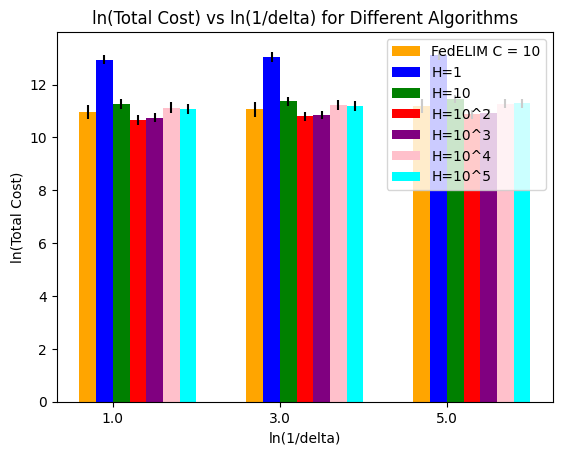

In [82]:
plot_results3(costs2, deltas)

In [80]:
costs2

{(0.3678794411714424, 10, 'FedELIM'): (58136.26, 15853.390384785203),
 (0.3678794411714424, 10, 'Periodic_1'): (415833.76, 73077.01776360608),
 (0.3678794411714424, 10, 'Periodic_10'): (77297.98, 15042.022136654366),
 (0.3678794411714424, 10, 'Periodic_100'): (42535.1, 7404.360268787575),
 (0.3678794411714424, 10, 'Periodic_1000'): (46588.5, 7575.8428408989585),
 (0.3678794411714424, 10, 'Periodic_14'): (68015.82, 13730.4610092888),
 (0.3678794411714424, 10, 'Periodic_15'): (64341.0, 11758.654132170059),
 (0.04978706836786394, 10, 'FedELIM'): (64171.18, 18487.167986676595),
 (0.04978706836786394, 10, 'Periodic_1'): (465897.8, 87634.32001196791),
 (0.04978706836786394, 10, 'Periodic_10'): (85857.0, 13563.558566983813),
 (0.04978706836786394, 10, 'Periodic_100'): (48988.4, 8583.295954352268),
 (0.04978706836786394, 10, 'Periodic_1000'): (51413.2, 8322.140215112937),
 (0.04978706836786394, 10, 'Periodic_14'): (74852.48, 13732.390755057912),
 (0.04978706836786394, 10, 'Periodic_15'): (7271